# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


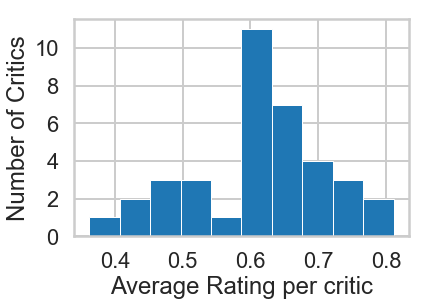

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);


<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

The general shape of the data is normal, with the exception being that we observe very few ratings of just below 0.6. The average critic seems to enjoy approximately 60% of the films they watch. I do not have a logical suggestion for why we do not observe many observations of just under 60% 'fresh' in the sample of critics making over 100 reviews.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
xx = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
xx = xx.toarray()

print("")
print("Transformed text vector is \n{}".format(xx))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [41]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    #print(vectorizer.get_feature_names())
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)
print(X.shape)
print(y.shape)

(15561, 22417)
(15561,)


<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [42]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=42)

MNB = MultinomialNB()

MNB.fit(X_train,y_train)

y_pred = MNB.predict(X_test)

print('training score:\n',MNB.score(X_train,y_train))
print('\ntest score:\n',MNB.score(X_test,y_test))
print('\nconfuion matrix:\n',confusion_matrix(y_test,y_pred))
print('\nclassification report:\n',classification_report(y_test,y_pred))

training score:
 0.9233382298934998

test score:
 0.7783251231527094

confuion matrix:
 [[1144  650]
 [ 385 2490]]

classification report:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69      1794
           1       0.79      0.87      0.83      2875

   micro avg       0.78      0.78      0.78      4669
   macro avg       0.77      0.75      0.76      4669
weighted avg       0.78      0.78      0.77      4669



This appears to be a relatively strong classifier. The training score was 0.92 and the test score only dropped to 0.78. This does not seem like a large drop when moving to the test data. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [8]:
# Your turn.

X_vectorizer = CountVectorizer()
X_v = X_vectorizer.fit_transform(critics.quote).toarray()
X_v = pd.DataFrame(X_v, columns=X_vectorizer.get_feature_names())

word_doc_freq = X_v.sum(axis=0).reset_index()
word_doc_freq.columns = ['Word','Frequency']
word_doc_freq.sort_values(['Frequency'],ascending=False).head(5)

,Word,Frequency
19917,the,16805
891,and,9904
13584,of,9778
20187,to,6238
10535,is,5974


In [9]:
#not how many times a word appears but...
#how many unique words appear 1 time, 2 times, 3 times, etc...
#ie. 9552 words appear only 1 time, 3486 words appear 2 times...

from collections import Counter

sorted_doc_freq = np.sort(word_doc_freq['Frequency'])
counts = Counter(sorted_doc_freq)
counts.most_common()[-5:]
#counts.most_common(5)

[(5974, 1), (6238, 1), (9778, 1), (9904, 1), (16805, 1)]

In [10]:
item_count = counts.items()
x_ax = np.array([item[0] for item in item_count])
freq = np.array([item[1] for item in item_count])
y_ax = freq.cumsum() / freq.sum()


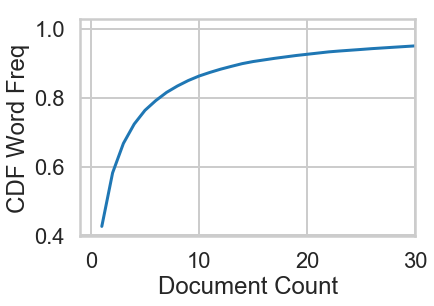

In [11]:
plt.plot(x_ax, y_ax)
plt.xlim(-1,30)
_ = plt.xlabel('Document Count')
_ = plt.ylabel('CDF Word Freq')

#min_df ~ 2
#max_df ~ 30

In [12]:
#not a count of the number of words that appear x times, but a count of the actual words

sorted2_doc_freq = word_doc_freq.sort_values('Frequency',ascending=False)
sorted2_doc_freq.head(3)

,Word,Frequency
19917,the,16805
891,and,9904
13584,of,9778


The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [13]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [14]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [15]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), test_size=0.3)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

(1) Using the log-likelihood score measures the probability of observing our data.

(2) Alpha is a measure of smoothing. An alpha that is too high might result in our model being too 'smooth' and misclassifying observations. A value too low and we might overfit our model. 

(3) Below

In [16]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 2 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
scores = []
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    
    # your turn
    MNB = MultinomialNB(alpha=alpha) #call the method
    score = cv_score(MNB, Xtrainthis, ytrainthis, log_likelihood) #score the method based on different alphas
    if score > maxscore: #if score from alpha is greater than prior score, update max
        maxscore = score
        best_alpha = alpha
    scores.append((alpha,score)) #add alpha and score to list each time through
scores #print alpha score pairs

[(0.1, -920.9907354318233),
 (1, -614.1728301585166),
 (5, -986.7973547699976),
 (10, -1205.2941444458468),
 (50, -1299.7097757751903)]

In [17]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [18]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.938317
Accuracy on test data:     0.741553


This classifier seems about the same as the prior. It does well on training data but has a large drop off on test data.

In [19]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2346 1892]
 [ 923 5731]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [20]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))


Good words	     P(fresh | word)
           beautiful 0.97
            stunning 0.96
            touching 0.95
            greatest 0.95
           memorable 0.93
              finest 0.93
             delight 0.93
              bright 0.93
            haunting 0.93
           absorbing 0.93
Bad words	     P(fresh | word)
          depressing 0.12
           pointless 0.12
              tricks 0.12
       unfortunately 0.11
            strictly 0.11
             muddled 0.10
           misguided 0.10
               tired 0.09
                lame 0.07
              merely 0.07


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

This tells us how likely a word is to appear in a 'fresh' with high probability words representing words that drive the results. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [21]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

As a depiction of a loving-turbulent relationship between a single mom (Susan Sarandon) and her rebellious teenage daughter (Natalie Portman), Wang's meller is nicely crafted but old-fashioned like Hollywood's weepies of yesteryear.

The Green Mile effectively sideswipes the enduring hot political issues it raises to force viewers to a pro-Hanks position.

The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

Cast of newcomers is appealing, but this small-town melodrama is so old-fashioned and out-of-touch with contemporary youth that it feels as if it were made the same time that its story is se

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [22]:
#your turn
E_VII = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']) 
clf.predict_proba(E_VII)

array([[0.00159253, 0.99840747]])

This does a poor job of classifying the results. It is a rotten sentence but is classified as fresh. Using single words does not account for the negation of the three positive words by using 'not'.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [23]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [24]:
# Your turn
import pandas as pd

#import movie reviews
critic_csv = pd.read_csv('critics.csv')

#let's drop rows with missing quotes
critic_csv = critic_csv[~critic_csv['quote'].isnull()]
critic_csv.head(5)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [25]:
#Basic EDA
n_reviews = len(critic_csv)
n_movies = critic_csv['rtid'].unique().size
n_critics = critic_csv['critic'].unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

#split main file into variables and outcomes
X = critic_csv['quote']
y = (critic_csv['fresh'] == 'fresh').values.astype(np.int)

#create training and test data
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=.3,random_state=42)

#vectorize and format data
bi_vectorizer = CountVectorizer(ngram_range=(1,2))
X_train_dtm = bi_vectorizer.fit_transform(X_train)

X_test_dtm = bi_vectorizer.transform(X_test)

#print(X_train_dtm.shape)
#print(y_train.shape)
#print(X_test_dtm.shape)
#print(y_test.shape)

#model building
MNB = MultinomialNB()
MNB.fit(X_train_dtm,y_train)

#predictions and accuracy
y_predict = MNB.predict(X_test_dtm)
test_acc = metrics.accuracy_score(y_test,y_predict)
train_acc = metrics.accuracy_score(y_train,MNB.predict(X_train_dtm))

print("Test Accuracy: " + str(int(test_acc*100)) + '%')
print("Train Accuracy: " + str(int(train_acc*100)) + '%')
print("Change in Relative Accuracy: " + str(int(((test_acc - train_acc)/train_acc)*100)) + '%')

Test Accuracy: 75%
Train Accuracy: 99%
Change in Relative Accuracy: -23%


In [27]:
#try a gridsearch of alpha values (manual?)
#try cross validation (manual?)
#try random forrest

In [28]:
a_vals = [.1,1,10,100]

train_acc_out = np.empty(len(a_vals))
test_acc_out = np.empty(len(a_vals))

for i in a_vals:
    MNB = MultinomialNB(alpha = i)
    MNB.fit(X_train_dtm,y_train)

#predictions and accuracy
    y_predict = MNB.predict(X_test_dtm)
    test_acc = metrics.accuracy_score(y_test,y_predict)
    train_acc = metrics.accuracy_score(y_train,MNB.predict(X_train_dtm))  
    print("For alpha of "+ str(i) + " Test Accuracy: " + str(test_acc*100) + '%')
    print("For alpha of "+ str(i) + " Train Accuracy: " + str(train_acc*100) + '%')
    print("For alpha of "+ str(i) + " Change in Accuracy: " + str(((test_acc - train_acc)/train_acc)*100) + '%')

For alpha of 0.1 Test Accuracy: 75.30520454058684%
For alpha of 0.1 Train Accuracy: 94.90451707675358%
For alpha of 0.1 Change in Accuracy: -20.65161189357919%
For alpha of 1 Test Accuracy: 77.18997644035124%
For alpha of 1 Train Accuracy: 92.44399559309585%
For alpha of 1 Change in Accuracy: -16.50082198944227%
For alpha of 10 Test Accuracy: 64.76761619190404%
For alpha of 10 Train Accuracy: 67.34300403966213%
For alpha of 10 Change in Accuracy: -3.824284176929945%
For alpha of 100 Test Accuracy: 61.55493681730563%
For alpha of 100 Train Accuracy: 60.71428571428571%
For alpha of 100 Change in Accuracy: 1.3846018167386889%


In [29]:
# setting the parameter grid
grid_parameters = {'alpha':[.1,1,10,100]}

# perform hyperparameter tuning
print("# Tuning hyper-parameters for accuracy\n")
MNB = MultinomialNB()
clf = GridSearchCV(MNB, grid_parameters, cv=5, scoring='accuracy')
clf.fit(X_train_dtm, y_train)

# view accuracy scores for all the models
print("Grid scores for all the models based on CV:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
# check out best model performance
print("\nBest parameters set found on development set:", clf.best_params_)
print("Best model validation accuracy:", clf.best_score_)

# Tuning hyper-parameters for accuracy

Grid scores for all the models based on CV:

0.74091 (+/-0.01068) for {'alpha': 0.1}
0.76047 (+/-0.00669) for {'alpha': 1}
0.63597 (+/-0.00437) for {'alpha': 10}
0.60696 (+/-0.00065) for {'alpha': 100}

Best parameters set found on development set: {'alpha': 1}
Best model validation accuracy: 0.7604663973558575


In [30]:
best_model = clf.best_estimator_
print(clf.best_estimator_)
print(best_model.score(X_test_dtm,y_test))

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
0.7718997644035125


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# setting the parameter grid
param_dist = {'alpha':uniform(0.1,10)}

# perform hyperparameter tuning
print("# Tuning hyper-parameters for accuracy\n")
MNB = MultinomialNB()
clf = RandomizedSearchCV(MNB, param_dist, cv=5, scoring='accuracy',n_iter=25)
clf.fit(X_train_dtm, y_train)

# view accuracy scores for all the models
print("Grid scores for all the models based on CV:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
# check out best model performance
print("\nBest parameters set found on development set:", clf.best_params_)
print("Best model validation accuracy:", clf.best_score_)

# Tuning hyper-parameters for accuracy

Grid scores for all the models based on CV:

0.63606 (+/-0.00456) for {'alpha': 9.99076966912022}
0.71566 (+/-0.01208) for {'alpha': 3.452728693114211}
0.74155 (+/-0.02019) for {'alpha': 2.4264054256698264}
0.73035 (+/-0.01791) for {'alpha': 2.833080735589505}
0.65039 (+/-0.00318) for {'alpha': 7.606862584127361}
0.64194 (+/-0.00277) for {'alpha': 8.904481050387762}
0.65002 (+/-0.00323) for {'alpha': 7.670884225189742}
0.67554 (+/-0.00713) for {'alpha': 5.433291714888817}
0.66397 (+/-0.00625) for {'alpha': 6.22903774878077}
0.65663 (+/-0.00458) for {'alpha': 6.88406496796777}
0.64396 (+/-0.00341) for {'alpha': 8.53510543048107}
0.63909 (+/-0.00408) for {'alpha': 9.359577542551756}
0.63671 (+/-0.00422) for {'alpha': 9.88548265591367}
0.69400 (+/-0.00718) for {'alpha': 4.354145821762621}
0.70768 (+/-0.01100) for {'alpha': 3.7953797689753577}
0.74192 (+/-0.01026) for {'alpha': 0.11412169678921771}
0.64717 (+/-0.00291) for {'alpha': 8.04937996376871}

In [32]:
c_space = np.logspace(-5,8,num=15)
c_space

array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])

In [36]:
# setting the parameter grid
from sklearn.linear_model import LogisticRegression

c_space = np.logspace(-5,10,num=7)
param_grid = {'C':c_space,'penalty':['l1','l2']}

# perform hyperparameter tuning
print("# Tuning hyper-parameters for accuracy\n")
LR = LogisticRegression()
clf = GridSearchCV(LR, param_grid, cv=5, scoring='accuracy')
clf.fit(X_train_dtm, y_train)

# view accuracy scores for all the models
print("Grid scores for all the models based on CV:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
# check out best model performance
print("\nBest parameters set found on development set:", clf.best_params_)
print("Best model validation accuracy:", clf.best_score_)

clf.best_estimator_
best_model = clf.best_estimator_
best_model.score(X_test_dtm,y_test)

print(means)

# Tuning hyper-parameters for accuracy



C:\Users\jrstark\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Grid scores for all the models based on CV:

0.39341 (+/-0.00018) for {'C': 1e-05, 'penalty': 'l1'}
0.60659 (+/-0.00018) for {'C': 1e-05, 'penalty': 'l2'}
0.60659 (+/-0.00018) for {'C': 0.0031622776601683794, 'penalty': 'l1'}
0.63193 (+/-0.00936) for {'C': 0.0031622776601683794, 'penalty': 'l2'}
0.74587 (+/-0.01318) for {'C': 1.0, 'penalty': 'l1'}
0.76037 (+/-0.01408) for {'C': 1.0, 'penalty': 'l2'}
0.72503 (+/-0.01865) for {'C': 316.22776601683796, 'penalty': 'l1'}
0.73063 (+/-0.01784) for {'C': 316.22776601683796, 'penalty': 'l2'}
0.70171 (+/-0.01022) for {'C': 100000.0, 'penalty': 'l1'}
0.72604 (+/-0.01976) for {'C': 100000.0, 'penalty': 'l2'}
0.69161 (+/-0.01834) for {'C': 31622776.60168379, 'penalty': 'l1'}
0.72521 (+/-0.01909) for {'C': 31622776.60168379, 'penalty': 'l2'}
0.69115 (+/-0.01260) for {'C': 10000000000.0, 'penalty': 'l1'}
0.72521 (+/-0.01945) for {'C': 10000000000.0, 'penalty': 'l2'}

Best parameters set found on development set: {'C': 1.0, 'penalty': 'l2'}
Best model

In [34]:
# setting the parameter grid
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors':np.arange(10,50,step=10)}

# perform hyperparameter tuning
print("# Tuning hyper-parameters for accuracy\n")
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
clf.fit(X_train_dtm, y_train)

# view accuracy scores for all the models
print("Grid scores for all the models based on CV:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
# check out best model performance
print("\nBest parameters set found on development set:", clf.best_params_)
print("Best model validation accuracy:", clf.best_score_)

# Tuning hyper-parameters for accuracy

Grid scores for all the models based on CV:

0.61256 (+/-0.00910) for {'n_neighbors': 10}
0.61385 (+/-0.01044) for {'n_neighbors': 20}
0.61339 (+/-0.00925) for {'n_neighbors': 30}
0.61596 (+/-0.01086) for {'n_neighbors': 40}

Best parameters set found on development set: {'n_neighbors': 40}
Best model validation accuracy: 0.6159566654425266


In [35]:
from sklearn.ensemble import RandomForestClassifier

p_grid = {'n_estimators':[50,100,200]}

RF = RandomForestClassifier()
clf = GridSearchCV(RF,p_grid,cv=5,scoring='accuracy')
clf.fit(X_train_dtm,y_train)

# view accuracy scores for all the models
print("Grid scores for all the models based on CV:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
    
# check out best model performance
print("\nBest parameters set found on development set:", clf.best_params_)
print("Best model validation accuracy:", clf.best_score_)

Grid scores for all the models based on CV:

0.69859 (+/-0.01956) for {'n_estimators': 50}
0.69822 (+/-0.02028) for {'n_estimators': 100}
0.70575 (+/-0.02175) for {'n_estimators': 200}

Best parameters set found on development set: {'n_estimators': 200}
Best model validation accuracy: 0.7057473374954095


In [ ]:
###decision tree???
###bagging with a single tree??
###do a random forest???
###do a tdvif???
